# Building Residential demand

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Extract population data for the area of interest
- **Part 2**: Get buildings from Google Building Footprint data and classify into groups per size and confidence level
- **Part 3**: Extract all "good candidates" of residential buildings
- **Part 4**: Assign demand based on formulation 

A slightly more detailed description of the processing bits is presented before each part below. <br />


In [1]:
%run BuildingDemand_funcs.ipynb

### Import necessary modules

In [1]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [2]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
import seaborn as sns

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

''

### Define directories and dataset names

In [2]:
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR + "\\" + 'Sample_Input'
out_path = ROOT_DIR + "\\" + 'Sample_Output'

## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "Copperbelt.gpkg"   

### Define coordinate and projection system

In [3]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Add functions

In [5]:
def processing_raster(name, method, clusters):
    messagebox.showinfo('OnSSET', 'Select the ' + name + ' map')
    raster=rasterio.open(filedialog.askopenfilename(filetypes = (("rasters","*.tif"),("all files","*.*"))))
    
    clusters = zonal_stats(
        clusters,
        raster.name,
        stats=[method],
        prefix=name, geojson_out=True, all_touched=True)
    
    print(datetime.datetime.now())
    return clusters

In [6]:
def finalizing_rasters(workspace, clusters, crs):
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(clusters)}
        dst.write(json.dumps(collection))
  
    clusters = gpd.read_file(output)
    os.remove(output)
    
    print(datetime.datetime.now())
    return clusters

### Import layer delineating the Area Of Interest (AoI)

In [4]:
## admininstrative boundary
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)

### Extraction of zonal stats

In [5]:
admin_gdf = processing_raster("buildings", "sum", admin_gdf)      #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-06-11 10:43:36.987983


In [20]:
admin_gdf = processing_raster("WorldPop", "sum", admin_gdf)           #Using Zambia 100m population layer; default values at WorldPopPeanutButter

2023-06-09 08:14:53.105513


In [21]:
admin_gdf = processing_raster("HRSL", "sum", admin_gdf)     #HRSL from Meta (2020) @ https://data.humdata.org/dataset/highresolutionpopulationdensitymaps-zmb

2023-06-09 08:15:08.655934


##### Once done with rasters run this cell

In [22]:
admin_gdf = finalizing_rasters(out_path, admin_gdf, crs_proj)

2023-06-09 08:15:11.626296


### Estimate number of residential buildings

In [23]:
pplperHH = 5.1          ## provide average household size

resbld = round(np.mean(list([admin_gdf.HRSLsum.sum(), admin_gdf.WorldPopsum.sum()]))/pplperHH)

print ("The data extraction indicated that in {} there are {:.0f} buildings & the population is: \n\
HRSL: {:.0f} \nWorldPop: {:.0f} \nThe estimated number of residential buildings is {}".format(admin_gdf.ADM1_NAME[0],
                                       admin_gdf.buildingssum.sum(),
                                       admin_gdf.HRSLsum.sum(),
                                       admin_gdf.WorldPopsum.sum(),
                                       resbld))


The data extraction indicated that in COPPERBELT there are 1014100 buildings & the population is: 
HRSL: 2498431 
WorldPop: 2129602 
The estimated number of residential buildings is 453729.0


### Let's find those buildings using Google building footprints 
Source: https://sites.research.google/open-buildings/

Note that the code for extraction from GEE is available in the repo; Run this and extract for the area of interest directly from GEE. We could potentially integrate "ee" here, but not a priority for now..

In [24]:
path= r"C:\Users\alexl\Dropbox\Self-employment\Imperial work\Zambia\GIS\GoogleBuildingFootprints"
#name6065kml = 'Copperbelt_t_060_065.kml'
#name6570kml = 'Copperbelt_t_065_070.kml'
#name70kml = 'Copperbelt_t_gte_070.kml'
name6065gpkg = 'Copperbelt_t_060_065.gpkg'
name6570gpkg = 'Copperbelt_t_065_070.gpkg'
name70gpkg = 'Copperbelt_t_gte_070.gpkg'

In [25]:
## Reading kml files into geopandas (not working only first 3 columns are imported)
#gpd.io.file.fiona.drvsupport.supported_drivers['kml'] = 'rw'
#
### Approach 1
#building = gpd.read_file(path + "\\" + name6065kml, driver='LIBKML')
#
### Approach 2
#fp=path + "\\" + name6065kml
#gdf_list = []
#for layer in fiona.listlayers(fp):    
#    gdf = gpd.read_file(fp, driver='kml', layer=layer)
#    gdf_list.append(gdf)
#gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

In [26]:
## Reading geopackages (converted kml to pkg in Qgis)
buildings6065 = gpd.read_file(path + "\\" + name6065gpkg)
buildings6570 = gpd.read_file(path + "\\" + name6570gpkg)
buildings70 = gpd.read_file(path + "\\" + name70gpkg)

In [27]:
# Concatenate the three GeoDataFrames into one
cols = ['Name', 'description', 'longitude_latitude', 'confidence', 
        'area_in_meters', 'system_index','full_plus_code', 'geometry']

## Merge layers into one
gBlds = gpd.GeoDataFrame(pd.concat([buildings6065, buildings6570, buildings70], ignore_index=True))

## Keep only useful columns
gBlds = gBlds[cols]

In [28]:
## Convert columns to float for processing
gBlds['area_in_meters'] = gBlds['area_in_meters'].astype(float)
gBlds['confidence'] = gBlds['confidence'].astype(float)

In [29]:
gBlds.shape

(1130701, 8)

In [43]:
#test = buildings6065.sample(frac=0.1, replace=True, random_state=1)

Text(0.5, 0, 'Building area')

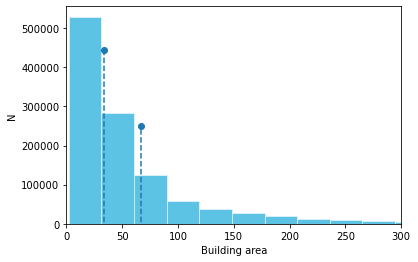

In [30]:
# Building count per unit area
sns.histplot(data = gBlds, bins=300, edgecolor='w', linewidth=0.5, \
            x="area_in_meters", color='#25afdc')
ylims = plt.gca().get_ylim()

stats = gBlds['area_in_meters'].describe()
plt.axvline(x= stats['50%'], ymin=-0.1, ymax=0.8,  ls='--', color='C0', marker ='o')

plt.axvline(x= stats['75%'], ymin=-0.1, ymax=0.45, ls='--', color='C0', marker ='o')

plt.xlim([0,300])
plt.ylim(ylims)
plt.ylabel("N")
plt.xlabel("Building area")
#plt.savefig("../figs/open_bldgs_area_hist.png", facecolor='white', transparent=False)

In [31]:
gBlds['area_type'] = pd.cut(gBlds['area_in_meters'],
                            bins=[0,30,50,100,300,float("inf")],
                            right=True, 
                            labels=['<30m²','30-50m²','50-100m²','100-300m²','>300m²'])

Text(0.5, 0, 'Building area')

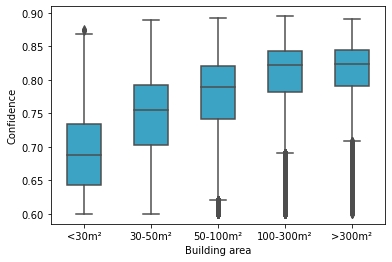

In [32]:
#confidence per area bin
sns.boxplot(data=gBlds, x='area_type', y ='confidence', color='#25afdc', width=0.5)
plt.ylabel("Confidence")
plt.xlabel("Building area")
#plt.savefig("../figs/open_bldgs_confidence_per_area.png", facecolor='white', transparent=False)

### Find "optimal" sub-set of buildings 
The following code will give you the m2 range and confidence level to reach a certain threshold number of buildings


**Note!** 

This is a simple solution for building selection based on the info we have at hand. There are resources available to explore more comprehensive classification ML-based techniques. Below are two examples that might be interesting to further explore. 

* [Using GIS and Machine Learning to Classify Residential Status of Urban Buildings in Low and Middle Income Settings](https://www.mdpi.com/2072-4292/12/23/3847)
* [Predicting residential structures from open source remotely enumerated data using machine learning](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0204399)
* [OSM_building_prediction - GitHub repo](https://github.com/disarm-platform/OSM_building_prediction)

In [33]:
resbld

453729.0

In [34]:
# Set the target number of buildings below
threshold = resbld

# These are calibrating parameteres
variance_area = 0.5
variance_conf = 0.01

# Define initial filtering parameters
HHarea = 45                                #This is the average size of a typical HH in the AoI in sq.m
conflevel = gBlds["confidence"].max()
endloop=False
gBlds_filtered = gBlds


# Loop until threshold is reached or no more rows can be filtered
while (len(gBlds_filtered) > threshold) & (endloop == False):
    gBlds_filtered = gBlds[((gBlds["area_in_meters"] >= HHarea - variance_area*HHarea) & 
                            (gBlds["area_in_meters"] <= HHarea + variance_area*HHarea))]
    # Action if building selection is still higher than threshold
    #print("test 1: {}".format(gBlds_filtered.shape[0]))
    if (len(gBlds_filtered) > threshold):
        min_conflevel = gBlds_filtered["confidence"].min()
        while (len(gBlds_filtered) > threshold) & (endloop == False):
            gBlds_filtered = gBlds[((gBlds["area_in_meters"] >= HHarea - variance_area*HHarea) &
                                    (gBlds["area_in_meters"] <= HHarea + variance_area*HHarea)) &
                                   (gBlds["confidence"] >= min_conflevel)]
            #print("test 2: {}".format(gBlds_filtered.shape[0]))
            if (len(gBlds_filtered) > threshold):
                if (min_conflevel < conflevel):
                    min_conflevel += variance_conf*min_conflevel
                    #print("test 3: {}".format(min_conflevel))
                else:
                    print("The min confidence level has been exhausted; we move on to a different set")
                    break
            else:
                while len(gBlds_filtered) < threshold:
                    variance_area += 0.01*variance_area
                    gBlds_filtered = gBlds[((gBlds["area_in_meters"] >= HHarea - variance_area*HHarea) &
                                            (gBlds["area_in_meters"] <= HHarea + variance_area*HHarea)) &
                                           (gBlds["confidence"] >= min_conflevel)]
                    #print("test 4: {}".format(gBlds_filtered.shape[0]))
                    if len(gBlds_filtered) > threshold:
                        endloop = True
                        #print("test 5: {}".format(gBlds_filtered.shape[0]))
                        m21 = HHarea + variance_area*HHarea
                        m22 = HHarea - variance_area*HHarea
                        conf = (min_conflevel - variance_conf*min_conflevel)*100
                        print("The optimal parameters for achieving the threshold you defined are m2:{:.2f}-{:.2f} and confidence level of {:.2f}%".format(m22, m21, conf))
                        break
                break
            
    else:
        break
    gBlds_filtered["Shortlisted"] = 1

The optimal parameters for achieving the threshold you defined are m2:22.05-67.95 and confidence level of 63.05%


In [35]:
print ("We can find {:.0f} buildings under the following parameterization: \n\
min HH size: {:.1f} \nMax HH size: {:.1f} \nConfidence level more than {:.2f}".format(gBlds_filtered.shape[0],
                                                                                     m22,
                                                                                     m21, 
                                                                                     conf))


We can find 459151 buildings under the following parameterization: 
min HH size: 22.0 
Max HH size: 68.0 
Confidence level more than 63.05


Text(0.5, 0, 'Building area')

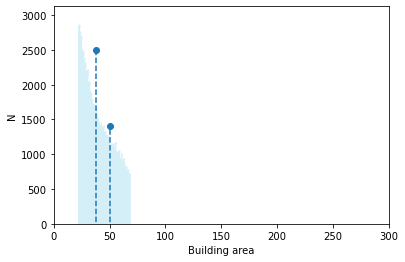

In [36]:
# Building count per unit area
sns.histplot(data = gBlds_filtered, bins=300, edgecolor='w', linewidth=0.5, \
            x="area_in_meters", color='#25afdc')
ylims = plt.gca().get_ylim()

stats = gBlds_filtered['area_in_meters'].describe()
plt.axvline(x= stats['50%'], ymin=-0.1, ymax=0.8,  ls='--', color='C0', marker ='o')

plt.axvline(x= stats['75%'], ymin=-0.1, ymax=0.45, ls='--', color='C0', marker ='o')

plt.xlim([0,300])
plt.ylim(ylims)
plt.ylabel("N")
plt.xlabel("Building area")
#plt.savefig("../figs/open_bldgs_area_hist.png", facecolor='white', transparent=False)

Text(0.5, 0, 'Building area')

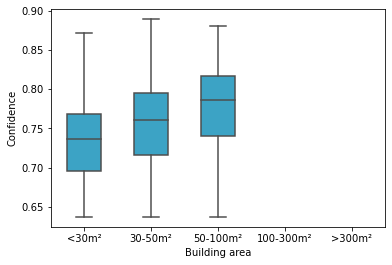

In [37]:
#confidence per area bin
sns.boxplot(data=gBlds_filtered, x='area_type', y ='confidence', color='#25afdc', width=0.5)
plt.ylabel("Confidence")
plt.xlabel("Building area")
#plt.savefig("../figs/open_bldgs_confidence_per_area.png", facecolor='white', transparent=False)

In [38]:
gBlds_filtered["area_in_meters"].value_counts(bins=4, sort=False)

(22.000999999999998, 33.524]    178992
(33.524, 45.0]                  121243
(45.0, 56.476]                   89762
(56.476, 67.952]                 69154
Name: area_in_meters, dtype: int64

### Merge with the global building dataset for further processing

In [39]:
gBlds = pd.merge(gBlds, gBlds_filtered[['system_index', 'Shortlisted']], on='system_index', how = 'left')

### Extract raster values to buildings

In [60]:
## Relative Wealth Index (RWI) -- extracting the mean value per building
## Link: https://gee-community-catalog.org/projects/rwi/

gBlds = processing_raster("rwi", "mean", gBlds)     

2023-05-28 14:59:08.259600


In [62]:
## GHS-BUILT-C -- The spatial raster dataset delineates the Morphological Settlement Zone (MSZ) and the inner classification of the morphology and the function of the built environment
## Link: https://ghsl.jrc.ec.europa.eu/ghs_buC2023.php

gBlds = processing_raster("GHSMSZ", "majority", gBlds)

2023-05-28 16:21:43.707758


In [63]:
## Average of the Net Building Height (ANBH)
## Link: https://ghsl.jrc.ec.europa.eu/ghs_buH2023.php

gBlds = processing_raster("GHSANBH", "mean", gBlds)

2023-05-29 00:11:09.923006


In [40]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html

gBlds = processing_raster("HREA", "mean", gBlds)

2023-06-09 09:30:51.736637


In [41]:
## When extraction is completed, run this cell to bring data to a pandas df mode
gBlds = finalizing_rasters(out_path, gBlds, crs_WGS84)

2023-06-09 09:36:35.340237


In [51]:
## OPTIONAL: Rename columns as/if needed
gBlds.rename({'HREAmean': 'HREA', 
              'GHSANBHmean_x': 'GHSANBH',
              'rwimean': 'rwi',
              'GHSMSZmajority': 'GHSMSZ'}, axis=1, inplace=True)

In [54]:
gBlds.head(3)

,id,Name,Shortlisted,area_in_meters,area_type,confidence,description,full_plus_code,longitude_latitude,system_index,HREA,geometry,GHSANBH,rwi,GHSMSZ
0,0,None,NaN,8.173100,<30m²,0.625,None,5GRC7MXR+MVH9,"{'type': 'Point', 'coordinates': [28.692250715...",04440000000000004393,NaN,"POLYGON ((28.69226 -13.70083, 28.69226 -13.700...",2.5,-0.434,0.0
1,1,None,NaN,31.574301,30-50m²,0.625,None,5GRCGR58+W9M7,"{'type': 'Point', 'coordinates': [28.815919423...",044400000000000054b4,0.069606,"POLYGON ((28.81596 -13.49018, 28.81590 -13.490...",2.5,-0.133,0.0
2,2,None,NaN,10.803500,<30m²,0.625,None,5GRCQQPH+6VPR,"{'type': 'Point', 'coordinates': [28.779689227...",04440000000000006e2b,0.060423,"POLYGON ((28.77971 -13.21442, 28.77970 -13.214...",2.5,-0.382,0.0


In [55]:
#gBlds.to_file(os.path.join(out_path,"{c}".format(c="gBlds.gpkg")), driver="GPKG")

In [56]:
gBlds.to_csv(os.path.join(out_path,"{c}".format(c="gBlds.csv")))